### Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4 - Градиентный бустинг


**Общая информация**

**Срок сдачи:** 10 мая 2021, 08:30   
**Штраф за опоздание:** -2 балла после 08:30 10 мая, -4 балла после 08:30 17 мая, -6 баллов после 08:30 24 мая, -8 баллов после 08:30 31 мая.

При отправлении ДЗ указывайте фамилию в названии файла Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:
[ML0221, Задание 4] Фамилия Имя. 


Используйте данный Ipython Notebook при оформлении домашнего задания.

##  Считаем производные для функций потерь (1 балл)

Мы будем реализовать градиентный бустинг для 3 функций потерь:

1) MSE  $L(a(x_i), y_i) = (y_i - a(x_i)) ^ 2$

2) Экспоненциальная  $L(a(x_i), y_i) = exp( -a(x_i) y_i), y_i \in \{-1, 1\}$

3) Логистическая  $L(a(x_i), y_i) = \log (1 + exp( -a(x_i) y_i)), y_i \in \{-1, 1\}$

где $a(x_i)$ предсказание бустинга на итом объекте. 

Для каждой функции потерь напишите таргет, на который будет настраиваться каждое дерево в бустинге. 

Ваше решение тут

In [2]:
def MSE_target(a_i, y):
    return 2 *(a_i - y)

def exp_target(a_i, y):
    return -y * np.exp(- y * a_i)

def log_target(a_i, y):
    return (- y * np.exp(-y * a_i)) / (1 + np.exp(-y * a_i))

##  Реализуем градиентный бустинг (3 балла)

Реализуйте класс градиентного бустинга для классификации. Ваша реализация бустинга должна работать по точности не более чем на 5 процентов хуже чем GradientBoostingClassifier из sklearn. 


Детали реализации:

-- должно поддерживаться 3 функции потерь

-- сами базовые алгоритмы(деревья, линейные модели и тп) реализовать не надо, просто возьмите готовые из sklearn

-- в качестве функции потерь для построения одного дерева используйте MSE

-- шаг в бустинге можно не подбирать, можно брать константный

-- можно брать разные модели в качестве инициализации бустинга

-- должны поддерживаться следующие параметры:

а) число итераций
б) размер шага
в) процент случайных фичей при построении одного дерева
д) процент случайных объектов при построении одного дерева
е) параметры базового алгоритма (передавайте через **kwargs)

In [93]:
import numpy as np

from sklearn.datasets import load_wine
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor, DummyClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor


import matplotlib.pyplot as plt

In [52]:
class MyGradientBoostingClassifier:

    def __init__(self, loss="logit", learning_rate=1, n_estimator=100, colsample=0.4, subsample=0.4, *args, **kwargs):
        """
        loss -- один из 3 лоссов:
        learning_rate -- шаг бустинга
        n_estimators -- число итераций
        colsample -- процент рандомных признаков при обучнеии одного алгоритма
        colsample -- процент рандомных объектов при обучнеии одного алгоритма
        args, kwargs -- параметры  базовых моделей
        """
        self.loss = loss
        self.learning_rate = learning_rate
        self.n_estimators = n_estimator
        self.colsample = colsample
        self.subsample = subsample
        self.arg_params = args
        self.kwarg_params = kwargs
        self.models = []
        
    def __calc_target_grad(self, models, X, y):
        if len(models) == 0:
            return np.random.uniform(size=y.shape[0])
        a_i = self._predict_est(X, models)
        if self.loss == "mse":
            return MSE_target(a_i, y)
        elif self.loss == "exponent":
            return exp_target(a_i, y)
        elif self.loss == "logit":
            return log_target(a_i, y)
        else:
            raise NotImplementedError("No such loss function")
        
        
    
    def fit(self, X, y, base_model=DecisionTreeRegressor, init_model=None):
        """
        X -- объекты для обучения:
        y -- таргеты для обучения
        base_model -- класс базовых моделей, например sklearn.tree.DecisionTreeRegressor
        init_model -- класс для первой модели, если None то берем константу (только для посл задания)
        """
        if init_model is not None:
            model = init_model()
        else:
            model = DummyRegressor(strategy="constant", constant=0.0)
        
        for i in range(self.n_estimators + 1):
            subsample_idx = np.random.choice(X.shape[0], round(X.shape[0] * self.subsample), replace=False)
            sub_X = X[subsample_idx]
            sub_y = y[subsample_idx]
            target_grad = self.__calc_target_grad(self.models, sub_X, sub_y)
            if i != 0:
                model = base_model(max_features=round(X.shape[1] * self.colsample), *self.arg_params, **self.kwarg_params)
            model.fit(sub_X, target_grad)
            self.models.append(model)
        return self
    
    def _predict_est(self, X, models=None):
        if models is None:
            models = self.models
        pred = models[0].predict(X)
        for m in models[1:]:
            pred += self.learning_rate * m.predict(X)
        return pred / len(models)
        
    def predict(self, X, models=None):
        return np.around(-self._predict_est(X, models)).astype(int)

In [62]:
my_clf = MyGradientBoostingClassifier()
clf = GradientBoostingClassifier()

In [63]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target)

In [64]:
my_clf.fit(X_train, y_train)
clf.fit(X_train, y_train)
print(accuracy_score(y_pred=clf.predict(X_test), y_true=y_test))
print(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

0.9444444444444444
0.9444444444444444


## Подбираем параметры (2 балла)

Давайте попробуем применить Ваш бустинг для предсказаний цены домов в Калифорнии. Чтобы можно было попробовать
разные функции потерь, переведем по порогу таргет в 2 класса: дорогие и дешевые дома.

В задании нужно

1) Построить график точности в зависимости от числа итераций на валидации.

2) Подобрать оптимальные параметры Вашего бустинга на валидации. 


In [67]:
from sklearn.datasets import fetch_california_housing
X, y = fetch_california_housing(return_X_y=True)

In [68]:
# Превращаем регрессию в классификацию
y = (y > 2.0).astype(int)
print(X.shape, y.shape)

(20640, 8) (20640,)


In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)

n_estimators: 20 accuracy: 0.7937659852197837
n_estimators: 60 accuracy: 0.8219204864345663
n_estimators: 100 accuracy: 0.826657935492657
n_estimators: 200 accuracy: 0.8295648224476165
n_estimators: 300 accuracy: 0.8327947821576913


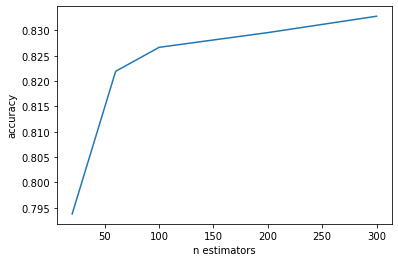

In [74]:
estimators = [20, 60, 100, 200, 300]

def find_best_n_estimators(est):
    accuracy = []
    for n_estimators in est:
        kf = KFold(n_splits=5)
        scores = []
        for train_index, val_index in kf.split(X_train):
            my_clf = MyGradientBoostingClassifier(learning_rate=1, n_estimator=n_estimators)
            data_train, data_val = X_train[train_index], X_train[val_index]
            target_train, target_val = y_train[train_index], y_train[val_index]
            my_clf.fit(data_train, target_train, DecisionTreeRegressor)
            prediction = my_clf.predict(data_val)
            score = accuracy_score(target_val, prediction)
            scores.append(score)
        scores = np.mean(scores)
        accuracy.append(scores)
        print(f"n_estimators: {n_estimators} accuracy: {scores}")
    return accuracy
n_estimators = find_best_n_estimators(estimators)

plt.xlabel('n estimators')
plt.ylabel('accuracy')
plt.plot(estimators, n_estimators)

subsample: 0.2 accuracy: 0.8121230516032666
subsample: 0.4 accuracy: 0.8276807287825951
subsample: 0.6 accuracy: 0.8372627914355297
subsample: 0.8 accuracy: 0.8442074503764594
subsample: 1 accuracy: 0.8508287468109244


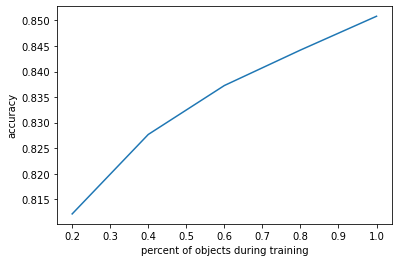

In [77]:
subsamples = [0.2, 0.4, 0.6, 0.8, 1]

def find_best_subsamples(subs):
    accuracy = []
    for subsample in subs:
        kf = KFold(n_splits=5)
        scores = []
        for train_index, val_index in kf.split(X_train):
            my_clf = MyGradientBoostingClassifier(learning_rate=1, n_estimator=100, subsample=subsample)
            data_train, data_val = X_train[train_index], X_train[val_index]
            target_train, target_val = y_train[train_index], y_train[val_index]
            my_clf.fit(data_train, target_train, DecisionTreeRegressor)
            prediction = my_clf.predict(data_val)
            score = accuracy_score(target_val, prediction)
            scores.append(score)
        scores = np.mean(scores)
        accuracy.append(scores)
        print(f"subsample: {subsample} accuracy: {scores}")
    return accuracy
accuracy = find_best_subsamples(subsamples)

plt.xlabel('percent of objects during training')
plt.ylabel('accuracy')
plt.plot(subsamples, accuracy)

colsample: 0.2 accuracy: 0.8437228122686516
colsample: 0.4 accuracy: 0.8488907883699603
colsample: 0.6 accuracy: 0.8474911444743694
colsample: 0.8 accuracy: 0.8454991184315179
colsample: 1 accuracy: 0.8317720613055906


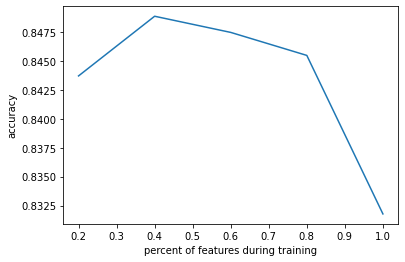

In [79]:
percent = [0.2, 0.4, 0.6, 0.8, 1]

def find_best_feat_percent(cols):
    accuracy = []
    for colsample in cols:
        kf = KFold(n_splits=5)
        scores = []
        for train_index, val_index in kf.split(X_train):
            my_clf = MyGradientBoostingClassifier(learning_rate=1, n_estimator=100, subsample=1, colsample=colsample)
            data_train, data_val = X_train[train_index], X_train[val_index]
            target_train, target_val = y_train[train_index], y_train[val_index]
            my_clf.fit(data_train, target_train, DecisionTreeRegressor)
            prediction = my_clf.predict(data_val)
            score = accuracy_score(target_val, prediction)
            scores.append(score)
        scores = np.mean(scores)
        accuracy.append(scores)
        print(f"colsample: {colsample} accuracy: {scores}")
    return accuracy
accuracy = find_best_feat_percent(percent)

plt.xlabel('percent of features during training')
plt.ylabel('accuracy')
plt.plot(percent, accuracy)

Depth: 3 accuracy: 0.6573525998664246
Depth: 5 accuracy: 0.720122419945324
Depth: 7 accuracy: 0.768302955318893
Depth: 10 accuracy: 0.814707126579326
Depth: 20 accuracy: 0.8494291029153331
Depth: 30 accuracy: 0.8491061605483254
Depth: 40 accuracy: 0.8503981907925715
Depth: 50 accuracy: 0.8495907407058633


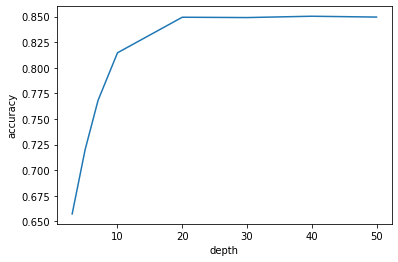

In [82]:
depth = [3, 5, 7, 10, 20, 30, 40, 50]

def find_best_max_depth(depth):
    accuracy = []
    for max_depth in depth:
        kf = KFold(n_splits=5)
        scores = []
        for train_index, val_index in kf.split(X_train):
            my_clf = MyGradientBoostingClassifier(loss='logit', learning_rate=1,\
                                                  n_estimator=100, subsample=1, colsample=0.4, max_depth=max_depth)
            data_train, data_val = X_train[train_index], X_train[val_index]
            target_train, target_val = y_train[train_index], y_train[val_index]
            my_clf.fit(data_train, target_train, DecisionTreeRegressor)
            prediction = my_clf.predict(data_val)
            score = accuracy_score(target_val, prediction)
            scores.append(score)
        scores = np.mean(scores)
        accuracy.append(scores)
        print(f"Depth: {max_depth} accuracy: {scores}")
    return accuracy
accuracy = find_best_max_depth(depth)

plt.xlabel('depth')
plt.ylabel('accuracy')
plt.plot(depth, accuracy)

learning rate: 0.01 accuracy: 0.5780571737363581
learning rate: 0.1 accuracy: 0.5780571737363581
learning rate: 0.3 accuracy: 0.5780571737363581
learning rate: 0.5 accuracy: 0.5780571737363581
learning rate: 0.7 accuracy: 0.5780571737363581
learning rate: 0.9 accuracy: 0.7994184545532251
learning rate: 1 accuracy: 0.8489984599715754


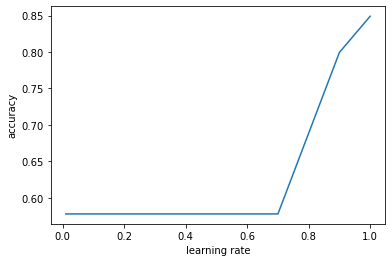

In [83]:
lr = [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]

def find_best_learning_rate(lr):
    accuracy = []
    for learning_rate in lr:
        kf = KFold(n_splits=5)
        scores = []
        for train_index, val_index in kf.split(X_train):
            my_clf = MyGradientBoostingClassifier(loss='logit', learning_rate=learning_rate, n_estimator=100,\
                                                  subsample=1, colsample=0.4, max_depth=30)
            data_train, data_val = X_train[train_index], X_train[val_index]
            target_train, target_val = y_train[train_index], y_train[val_index]
            my_clf.fit(data_train, target_train, DecisionTreeRegressor)
            prediction = my_clf.predict(data_val)
            score = accuracy_score(target_val, prediction)
            scores.append(score)
        scores = np.mean(scores)
        accuracy.append(scores)
        print(f"learning rate: {learning_rate} accuracy: {scores}")
    return accuracy
accuracy = find_best_learning_rate(lr)

plt.xlabel('learning rate')
plt.ylabel('accuracy')
plt.plot(lr, accuracy)

##### Получившееся параметры: loss = "logit", learning_rate = 1, n_estimators = 100, subsample = 1.0, colsample = 0.4, max_depth = 30

In [85]:
my_clf = MyGradientBoostingClassifier(loss='logit', learning_rate=1,\
                                      n_estimator=100, subsample=1, colsample=0.4, max_depth=30)
my_clf.fit(X_train, y_train, DecisionTreeRegressor)
max_accuracy = accuracy_score(my_clf.predict(X_test), y_test)
print(max_accuracy)

0.8531976744186046


## BooBag BagBoo (1 балл)



Попробуем объединить бустинг и бэгинг. Давайте

1) в качестве базовой модели брать не дерево решений, а случайный лес (из sklearn)

2) обучать N бустингов на бустрапированной выборке, а затем предикт усреднять

Попробуйте обе этих стратегии на данных из прошлого задания. Получилось ли улучшить качество? Почему?

In [92]:
my_clf = MyGradientBoostingClassifier(loss='logit', learning_rate=1, n_estimator=100, subsample=1,\
                                      colsample=0.4, n_estimators=100)
my_clf.fit(X_train, y_train, RandomForestRegressor)

(max_accuracy, accuracy_score(my_clf.predict(X_test), y_test))

(0.8531976744186046, 0.8406007751937985)

In [91]:
classificators = []
for _ in range(50):
    i_dx = np.random.choice(X_train.shape[0], X_train.shape[0], replace=True)
    X_sub = X_train[i_dx]
    y_sub = y_train[i_dx]
    my_clf = MyGradientBoostingClassifier(loss='logit', learning_rate=1, n_estimator=100, subsample=1, colsample=0.4)
    my_clf.fit(X_sub, y_sub, DecisionTreeRegressor)
    classificators.append(my_clf)

prediction = classificators[0].predict(X_test)
for m in classificators[1:]:
    prediction += m.predict(X_test)
prediction = (np.around(prediction/len(classificators))).astype(int)

(max_accuracy, accuracy_score(prediction, y_test))

(0.8531976744186046, 0.8473837209302325)

#### Вывод:
BagBoo и BooBag имеют больше гиперпараметров для настройки (отдельно гиперпараметры baggingа и отдельно boostingа), что делает их сложнее в применении. В принципе, при хорошей настройке результат должен быть лучше, но в данном случае добиться улучшения не удалось.

## Умная инициализация (1 балл)

Попробуйте брать в качестве инициализации бустинга не константу, а какой-то алгоритм и уже от его предикта стартовать итерации бустинга. Попробуйте разные модели из sklearn: линейные модели, рандом форест, svm..

Получилось ли улучшить качество? Почему?



In [94]:
my_clf = MyGradientBoostingClassifier(loss='logit', learning_rate=1, n_estimator=100, subsample=1,\
                                      colsample=0.4, max_depth=20)

In [95]:
my_clf.fit(X_train, y_train, DecisionTreeRegressor, init_model=None)
accuracy = accuracy_score(my_clf.predict(X_test), y_test)
print(f"model: constant; accuracy: {accuracy}")

model: constant; accuracy: 0.8527131782945736


In [96]:
my_clf.fit(X_train, y_train, DecisionTreeRegressor, init_model=LinearRegression)
accuracy = accuracy_score(my_clf.predict(X_test), y_test)
print(f"model: Linear Regressor; accuracy: {accuracy}")

model: Linear Regressor; accuracy: 0.8561046511627907


In [97]:
my_clf.fit(X_train, y_train, DecisionTreeRegressor, init_model=KNeighborsRegressor)
accuracy = accuracy_score(my_clf.predict(X_test), y_test)
print(f"model: KNeighbors Regressor; accuracy: {accuracy}")

model: KNeighbors Regressor; accuracy: 0.8565891472868217


In [98]:
my_clf.fit(X_train, y_train, DecisionTreeRegressor, init_model=DecisionTreeRegressor)
accuracy = accuracy_score(my_clf.predict(X_test), y_test)
print(f"model: DecisionTree Regressor; accuracy: {accuracy}")

model: DecisionTree Regressor; accuracy: 0.8565891472868217


In [99]:
my_clf.fit(X_train, y_train, DecisionTreeRegressor, init_model=RandomForestRegressor)
accuracy = accuracy_score(my_clf.predict(X_test), y_test)
print(f"model: RandomForest Regressor; accuracy: {accuracy}")

model: RandomForest Regressor; accuracy: 0.8570736434108527


In [102]:
my_clf.fit(X_train, y_train, DecisionTreeRegressor, init_model=SVR)
accuracy = accuracy_score(my_clf.predict(X_test), y_test)
print(f"model: SVR; accuracy: {accuracy}")

model: SVR; accuracy: 0.8565891472868217


#### Вывод:
Наибольший потенциал имеет использование RandomForestRegressor.


Чуть хуже работают SVR, DecisionTreeRegressor, KNeighborsRegressor, LinearRegressor.


Проблема та же - больше гиперпараметров, требуется лучшая настройка.

## Фидбек (бесценно)

* Какие аспекты обучения  ансамблей Вам показались непонятными? Какое место стоит дополнительно объяснить?

### Ваш ответ здесь

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.

### ВАШ ОТЗЫВ ЗДЕСЬ

